In [1]:
import pandas as pd # To load the data
import matplotlib.pyplot as plt # To draw figures
import matplotlib.pylab 
from datetime import datetime, timedelta # Handle datetime
import numpy as np
from fastai.collab import *
from fastai.tabular import *
from time import *
from IPython import display as cleardisplay

In [2]:
import TriPhaseController as tpc

In [3]:
db = tpc.Database()

In [4]:
from fastai.tabular.all import *

In [5]:
# Custom loss for multi-point forecasting

def multiPointLoss(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = F.mse_loss(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = torch.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = torch.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score

In [6]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [7]:
#from fastai import *
learn = load_learner("FNN_multipoint_12p.pth")

In [8]:
learn.model.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(8, 5)
    (1): Embedding(25, 10)
    (2): Embedding(3, 3)
    (3): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=25, out_features=1000, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=1000, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=500, out_features=12, bias=True)
    )
    (3): SigmoidRange(low=0, high=36)
  )
)

In [9]:
import pytz
netherlands = pytz.timezone('Europe/Amsterdam')

In [10]:
import holidays

In [11]:
from wwf.tab.export import *
to_load = load_pandas('PP.pkl')

In [12]:
from threading import Timer

In [13]:
import csv
import collections

In [14]:
import os
import re
def auto_save_file(path):
    directory, file_name=os.path.split(path)
    while os.path.isfile(path):
        pattern="(\d+)\)\."
        if re.search(pattern, file_name) is None:
            file_name=file_name.replace(".", "(0).")
        else:
            current_number=int(re.findall(pattern, file_name)[-1])
            new_number=current_number + 1
            file_name=file_name.replace(f"({current_number}).", f"({new_number}).")
        path=os.path.join(directory + os.sep + file_name)
    return file_name

In [15]:
"""
At minute 10:
    Read the last 3 line of Grid and PV from the database.
    Store predictions:
        Day(dd/mm/yy) & Hour & Energy of the last hour & Prediction 1 & ... & Prediction 12
    Draw the graph:
        Grpah includes 24 points: 12 previous points and 12 predicted points
        Also previous predictions?
"""
# 12-point lists for historical data and predictions
Measured_ls = collections.deque([], maxlen=12)
OldPredictions_ls = collections.deque([], maxlen=12)
NewPredictions_ls = collections.deque([], maxlen=12)

header = ['Day', 'Weekday', 'Hour', 'E_LastHour', 'E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6', 'E_7', 'E_8', 'E_9', 'E_10', 'E_11', 'E_12']

mypath ="."
#fname = mypath + "/" + "_prediction.txt"
fname = mypath + "/" + "demand_prediction.csv"
demand_pred = auto_save_file(fname)

with open(demand_pred, 'a', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

def chrontask():
    # Get current hour
    hour_now = datetime.today().hour
    
    # Read grid and PV data
    grid_df = db.read_Grid_df(hours=4)
    pv_df = db.read_PV_df(hours=4)
    
    # Append the row for current hour if there is not one
    new_time = datetime.now().replace(microsecond=0, second=0, minute=0)
    
    if pv_df.index[-1].tz_localize('GMT').tz_convert(netherlands).hour != hour_now:
        new_data = pd.DataFrame(pv_df[-1:].values, index=[new_time], columns=pv_df.columns)
        pv_df = pd.concat([pv_df,new_data])
        
    if grid_df.index[-1].tz_localize('GMT').tz_convert(netherlands).hour != hour_now:
        new_data = pd.DataFrame(grid_df[-1:].values, index=[new_time], columns=grid_df.columns)
        grid_df = pd.concat([grid_df,new_data])
    
    # Calculate the energy demand of previous hours
    ev_df = grid_df.copy()
    ev_df['Energy_kWh'] = pv_df['Energy_kWh'] - grid_df['Energy_kWh']
    
    # Get weekday and hour from time index
    ev_df['weekday']=ev_df.index.tz_localize('GMT').tz_convert(netherlands).day_of_week
    ev_df['hour']=ev_df.index.tz_localize('GMT').tz_convert(netherlands).hour
    
    # Mark the holidays
    ev_df['hols'] = pd.Series(ev_df.index).apply(lambda x: holidays.CountryHoliday('NL').get(x)).values
    
    # Add HAN breaks
    # https://www.hanuniversity.com/en/study-and-living/studying-at-han/academic-calendar/#
    # https://schoolholidayseurope.eu/school-holidays-holland/
    ev_df.loc[(ev_df.index > '2022-05-01 23:00:00') & (ev_df.index < '2022-05-09 00:00:00'), 'hols'] = 'May holiday'
    ev_df.loc[(ev_df.index > '2022-07-10 23:00:00') & (ev_df.index < '2022-08-15 00:00:00'), 'hols'] = 'Summer break'
    ev_df.loc[(ev_df.index > '2022-10-21 23:00:00') & (ev_df.index < '2022-11-01 00:00:00'), 'hols'] = 'Fall holiday'
    ev_df.loc[(ev_df.index > '2022-12-23 23:00:00') & (ev_df.index < '2023-01-09 00:00:00'), 'hols'] = 'Winter break'
    ev_df.loc[(ev_df.index > '2023-02-17 23:00:00') & (ev_df.index < '2023-02-27 00:00:00'), 'hols'] = 'Spring holiday'
    
    # Clean the data
    ev_df.loc[ev_df.Energy_kWh < 0,'Energy_kWh'] = 0
    ev_df['is_hol'] = ~ev_df.isna()['hols']
    ev_df['measure'] = 0
    
    # Other information
    ev_df['E_1'] = ev_df['Energy_kWh']
    ev_df['E_2'] = ev_df['Energy_kWh']
    ev_df['E_3'] = ev_df['Energy_kWh']
    ev_df['E_1'] = ev_df.E_1.shift(1)
    ev_df['E_2'] = ev_df.E_2.shift(2)
    ev_df['E_3'] = ev_df.E_3.shift(3)
    
    # Drop un-used data
    ev_df.reset_index(inplace=True, drop=True)
    ev_df.drop(['Energy_kWh','hols'], axis=1, inplace=True)
    
    # Get only the row of previous hour
    ev_df_in = ev_df.iloc[-1:,:].copy()
    ev_df_in.reset_index(inplace=True, drop=True)
    
    # Create dummy data to run the model, the values are not important
    ev_df_in.loc[:,'Energy_kWh'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_1'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_2'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_3'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_4'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_5'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_6'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_7'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_8'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_9'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_10'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_11'] = 0.0
    
    # Preprocess data
    to_test = to_load.train.new(ev_df_in)
    to_test.process()
    dls = to_test.dataloaders()
    
    # Predict
    preds,targs = learn.get_preds(dl=dls[0])
    
    # Store data to queues
    for i in preds[0]:
        NewPredictions_ls.append(i)
        
    OldPredictions_ls.append(NewPredictions_ls[0])
    Measured_ls.append(ev_df_in['E_1'].item())
    
    Predictions_ls = collections.deque([], maxlen=24)
    for i in OldPredictions_ls:
        Predictions_ls.append(i)
    for i in NewPredictions_ls:
        Predictions_ls.append(i)
        
    # Write data to .csv file
    with open(demand_pred, 'a', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        data = [datetime.today().strftime("%m/%d/%y"), datetime.today().weekday(), hour_now, ev_df_in.iloc[0]['E_1'],\
               preds[0][0].numpy(),preds[0][1].numpy(),preds[0][2].numpy(),preds[0][3].numpy(),preds[0][4].numpy(),preds[0][5].numpy(),\
               preds[0][6].numpy(),preds[0][7].numpy(),preds[0][8].numpy(),preds[0][9].numpy(),preds[0][10].numpy(),preds[0][11].numpy()]
        
        writer.writerow(data)
        
    plt.clf()
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(Predictions_ls, color='g', label='Predictions')
    plt.plot(Measured_ls, color='r', label='Actual values')
    
    cleardisplay.clear_output(wait=True)
    cleardisplay.display(plt.gcf())

In [16]:
import schedule

In [17]:
#chrontask()

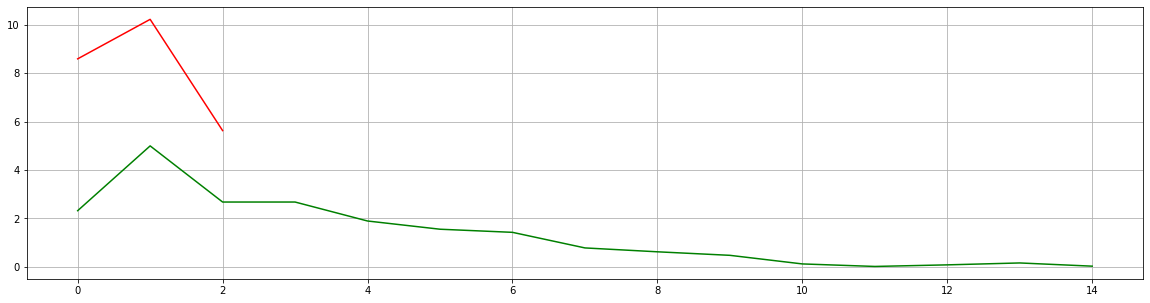

In [ ]:
schedule.every().hour.at(":10").do(chrontask)
#schedule.every().minute.do(chrontask)

while True:
    schedule.run_pending()
    time.sleep(1)